# Employee Performance With Resign Prediction Using Deep Learning (3)

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# library dibawah sebenarnya udah ada di pyforest
from sklearn.model_selection       import train_test_split
from sklearn.feature_selection     import SelectKBest, f_classif
from sklearn.preprocessing         import MinMaxScaler, StandardScaler
from sklearn.preprocessing         import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline              import make_pipeline
from sklearn.compose               import ColumnTransformer
from sklearn.metrics               import (f1_score,
                                           precision_score,
                                           recall_score,
                                           log_loss,
                                           accuracy_score,
                                           classification_report,
                                           ConfusionMatrixDisplay,
                                           confusion_matrix)


from pyspark.sql                   import SparkSession
from sklearn.ensemble              import StackingClassifier
from sklearn.pipeline              import Pipeline
from sklearn.preprocessing         import StandardScaler
from sklearn_pandas                import DataFrameMapper
from sklearn.ensemble              import AdaBoostClassifier
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.linear_model          import LogisticRegression
from matplotlib.colors             import ListedColormap
from sklearn.linear_model          import SGDClassifier
from sklearn.ensemble              import RandomForestClassifier
from sklearn.linear_model          import SGDClassifier
from sklearn.svm                   import SVC
from sklearn.naive_bayes           import GaussianNB
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.neighbors             import NeighborhoodComponentsAnalysis
from keras.callbacks               import EarlyStopping

In [3]:
# env
os.environ['HADOOP_HOME'] = r"C:\hadoop"
os.environ['HADOOP_CONF_DIR'] = r"C:\hadoop\etc\hadoop"
os.environ['JAVA_HOME'] = r"C:\Java"  # path jdk

# sesi spark
spark = SparkSession.builder \
    .appName("Hadoop Clustering Performa Karyawan") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .config("spark.yarn.stagingDir", "/user/ASUS/.sparkStaging") \
    .getOrCreate()

In [4]:
# data hdfs
hdfs_path = "/user/ASUS/hadoop_clustering_employee_turnover/cluster.csv"
data_hadoop = spark.read.csv(hdfs_path, header=True, inferSchema=True)

<IPython.core.display.Javascript object>

In [5]:
df = pd.DataFrame(data_hadoop)

<IPython.core.display.Javascript object>

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tingkat_kepuasan            14999 non-null  float64
 1   evaluasi_terakhir           14999 non-null  float64
 2   jumlah_proyek               14999 non-null  int64  
 3   rata-rata_jam_bulan         14999 non-null  int64  
 4   waktu_spent_for_perusahaan  14999 non-null  int64  
 5   Kecelakaan_kerja            14999 non-null  int64  
 6   resign                      14999 non-null  int64  
 7   promosi_5tahun_terakhir     14999 non-null  int64  
 8   gaji                        14999 non-null  int64  
 9   IT                          14999 non-null  int64  
 10  RandD                       14999 non-null  int64  
 11  accounting                  14999 non-null  int64  
 12  hr                          14999 non-null  int64  
 13  management                  149

In [7]:
X = df.drop('resign', axis=1)
y = pd.DataFrame(df['resign'])

<IPython.core.display.Javascript object>

In [8]:
hapus = ['accounting',
        'product_mng',
        'IT',
        'support',
        'sales',
        'evaluasi_terakhir',
        'marketing']

In [9]:
X = X.drop(hapus, axis=1).sort_index()
X

,tingkat_kepuasan,jumlah_proyek,rata-rata_jam_bulan,waktu_spent_for_perusahaan,Kecelakaan_kerja,promosi_5tahun_terakhir,gaji,RandD,hr,management,technical,cluster
0,0.38,2,157,3,0,0,0,0,0,0,0,2
1,0.80,5,262,6,0,0,1,0,0,0,0,3
2,0.11,7,272,4,0,0,1,0,0,0,0,3
3,0.72,5,223,5,0,0,0,0,0,0,0,0
4,0.37,2,159,3,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.40,2,151,3,0,0,0,0,0,0,0,2
14995,0.37,2,160,3,0,0,0,0,0,0,0,2
14996,0.37,2,143,3,0,0,0,0,0,0,0,4
14997,0.11,6,280,4,0,0,0,0,0,0,0,3


In [10]:
y

,resign
0,1
1,1
2,1
3,1
4,1
...,...
14994,1
14995,1
14996,1
14997,1


In [11]:
y.dtypes

resign    int64
dtype: object

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42)

In [13]:
X_train.shape

(11249, 12)

### Neural Network

In [14]:
# y_true itu y_test
def model_report(y_true, y_pred):

    acc                     = accuracy_score(y_true, y_pred)
    pre                     = precision_score(y_true, y_pred)
    rec                     = recall_score(y_true, y_pred)
    f1                      = f1_score(y_true, y_pred)
    loss                    = log_loss(y_true, y_pred)

    print("accuracy:   {:3f}\nprecision:  {:3f}\nrecall:     {:3f}\nf1-score:   {:3f}\nloss:       {:3f}".
          format(acc, pre, rec, f1, loss))

In [15]:
# Fungsi Evaluasi Suatu Model dengan Confusion Matrix
def plot_confusion_matriks(y_true, y_pred):
    cm    = confusion_matrix(y_true, y_pred)
    tampil = ConfusionMatrixDisplay(confusion_matrix=cm)

    tampil.plot(cmap='Greys')

    plt.title('Confusion Matrix')
    plt.show()

In [45]:
def pred_report_nn(y_true, y_pred):

    # Konversi prediksi yang kontinu menjadi nilai biner (0/1)
    y_pred_bin = np.round(y_pred).astype(int)

    # Hitung metrik evaluasi klasifikasi
    acc_ann    = accuracy_score(y_true, y_pred_bin)
    pre_ann    = precision_score(y_true, y_pred_bin)
    rec_ann    = recall_score(y_true, y_pred_bin)
    f1_ann     = f1_score(y_true, y_pred_bin)
    loss_ann   = log_loss(y_true, y_pred)

    print("Accuracy:  {:3f}\nPrecision:  {:3f}\nRecall:  {:3f}\nF1 Score:  {:3f}\nLoss:  {:3f}".
          format(acc_ann, pre_ann, rec_ann, f1_ann, loss_ann))

In [18]:
print(X_train.shape)
print(X_test.shape)

(11249, 12)
(3750, 12)


In [19]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=10)

<IPython.core.display.Javascript object>

In [20]:
ann_model = keras.Sequential()

ann_model.add(keras.layers.Dense(units=24, input_shape=(12,)))
ann_model.add(keras.layers.LeakyReLU(alpha=0.01))
ann_model.add(keras.layers.Dropout(0.1)) #untuk antisipasi overfit

ann_model.add(keras.layers.Dense(units=12))
ann_model.add(keras.layers.LeakyReLU(alpha=0.01))
ann_model.add(keras.layers.Dropout(0.2))

ann_model.add(keras.layers.Dense(units=6))
ann_model.add(keras.layers.LeakyReLU(alpha=0.01))
ann_model.add(keras.layers.Dropout(0.15))

ann_model.add(keras.layers.Dense(units=1, activation="sigmoid")) #output

ann_model.compile(optimizer=keras.optimizers.AdamW(0.01), #learning rate
                 loss="mse",
                 metrics=["accuracy"])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
ann_latih = ann_model.fit(X_train, y_train,
                         epochs=50,
                         validation_split=0.2,
                         callbacks=[early_stopping],
                         verbose=2)

Epoch 1/50
282/282 - 5s - 17ms/step - accuracy: 0.7563 - loss: 0.2356 - val_accuracy: 0.7671 - val_loss: 0.2329
Epoch 2/50
282/282 - 1s - 4ms/step - accuracy: 0.7609 - loss: 0.2322 - val_accuracy: 0.7671 - val_loss: 0.2329
Epoch 3/50
282/282 - 1s - 4ms/step - accuracy: 0.7609 - loss: 0.2306 - val_accuracy: 0.7671 - val_loss: 0.2329
Epoch 4/50
282/282 - 1s - 4ms/step - accuracy: 0.7611 - loss: 0.2297 - val_accuracy: 0.7671 - val_loss: 0.1790
Epoch 5/50
282/282 - 1s - 4ms/step - accuracy: 0.7611 - loss: 0.1829 - val_accuracy: 0.7671 - val_loss: 0.1786
Epoch 6/50
282/282 - 1s - 5ms/step - accuracy: 0.7611 - loss: 0.1819 - val_accuracy: 0.7671 - val_loss: 0.1786
Epoch 7/50
282/282 - 1s - 4ms/step - accuracy: 0.7611 - loss: 0.1819 - val_accuracy: 0.7671 - val_loss: 0.1784
Epoch 8/50
282/282 - 1s - 5ms/step - accuracy: 0.7611 - loss: 0.1817 - val_accuracy: 0.7671 - val_loss: 0.1783
Epoch 9/50
282/282 - 1s - 4ms/step - accuracy: 0.7611 - loss: 0.1814 - val_accuracy: 0.7671 - val_loss: 0.1777


In [24]:
ann_model3 = keras.Sequential()

ann_model3.add(keras.layers.Dense(units=64, activation="relu", input_shape=(12,)))
ann_model3.add(keras.layers.Dropout(0.3))

ann_model3.add(keras.layers.Dense(units=32, activation="relu"))
ann_model3.add(keras.layers.Dropout(0.3))

ann_model3.add(keras.layers.Dense(units=16, activation="relu"))
ann_model3.add(keras.layers.Dropout(0.2))

ann_model3.add(keras.layers.Dense(units=1, activation="sigmoid"))

ann_model3.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001), 
                   loss="binary_crossentropy",
                   metrics=["accuracy"])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
ann_latih3 = ann_model3.fit(X_train, y_train,
                            epochs=100,
                            validation_split=0.2,
                            callbacks=[early_stopping],
                            verbose=2)

Epoch 1/100
282/282 - 4s - 14ms/step - accuracy: 0.6430 - loss: 1.8505 - val_accuracy: 0.7671 - val_loss: 0.6345
Epoch 2/100
282/282 - 1s - 4ms/step - accuracy: 0.7479 - loss: 0.6130 - val_accuracy: 0.7671 - val_loss: 0.5800
Epoch 3/100
282/282 - 1s - 4ms/step - accuracy: 0.7582 - loss: 0.5801 - val_accuracy: 0.7671 - val_loss: 0.5594
Epoch 4/100
282/282 - 1s - 5ms/step - accuracy: 0.7601 - loss: 0.5674 - val_accuracy: 0.7671 - val_loss: 0.5485
Epoch 5/100
282/282 - 1s - 4ms/step - accuracy: 0.7608 - loss: 0.5630 - val_accuracy: 0.7671 - val_loss: 0.5461
Epoch 6/100
282/282 - 1s - 5ms/step - accuracy: 0.7608 - loss: 0.5563 - val_accuracy: 0.7671 - val_loss: 0.5463
Epoch 7/100
282/282 - 1s - 5ms/step - accuracy: 0.7610 - loss: 0.5558 - val_accuracy: 0.7671 - val_loss: 0.5467
Epoch 8/100
282/282 - 1s - 4ms/step - accuracy: 0.7612 - loss: 0.5445 - val_accuracy: 0.7671 - val_loss: 0.5248
Epoch 9/100
282/282 - 1s - 4ms/step - accuracy: 0.7611 - loss: 0.5312 - val_accuracy: 0.7671 - val_loss

In [27]:
from tensorflow.keras.callbacks import LearningRateScheduler

def learning_rate_scheduler(epoch, lr):
    
    if epoch % 10 == 0 and epoch != 0:
        lr = lr * 0.1
        
    return lr

In [28]:
lr_schedul = LearningRateScheduler(learning_rate_scheduler)

In [29]:
ann_model4 = keras.Sequential()

ann_model4.add(keras.layers.Dense(units=12, activation="relu", input_shape=(12,)))
ann_model4.add(keras.layers.Dropout(0.3))

ann_model4.add(keras.layers.Dense(units=6, activation="relu"))
ann_model4.add(keras.layers.Dropout(0.2))

ann_model4.add(keras.layers.Dense(units=1, activation="sigmoid"))

ann_model4.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.01), 
                   loss="binary_crossentropy",
                   metrics=["accuracy"])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
ann_model4.fit(X_train,
               y_train,
               epochs=100,
               batch_size=128,
               validation_split=0.2,
               callbacks=[lr_schedul, early_stopping],
               verbose=2)

Epoch 1/100
71/71 - 3s - 38ms/step - accuracy: 0.7239 - loss: 1.6885 - val_accuracy: 0.7671 - val_loss: 0.5690 - learning_rate: 0.0100
Epoch 2/100
71/71 - 0s - 5ms/step - accuracy: 0.7589 - loss: 0.5599 - val_accuracy: 0.7671 - val_loss: 0.5438 - learning_rate: 0.0100
Epoch 3/100
71/71 - 0s - 5ms/step - accuracy: 0.7611 - loss: 0.5499 - val_accuracy: 0.7671 - val_loss: 0.5427 - learning_rate: 0.0100
Epoch 4/100
71/71 - 0s - 5ms/step - accuracy: 0.7611 - loss: 0.5504 - val_accuracy: 0.7671 - val_loss: 0.5431 - learning_rate: 0.0100
Epoch 5/100
71/71 - 0s - 5ms/step - accuracy: 0.7611 - loss: 0.5502 - val_accuracy: 0.7671 - val_loss: 0.5427 - learning_rate: 0.0100
Epoch 6/100
71/71 - 0s - 5ms/step - accuracy: 0.7611 - loss: 0.5500 - val_accuracy: 0.7671 - val_loss: 0.5429 - learning_rate: 0.0100
Epoch 7/100
71/71 - 0s - 5ms/step - accuracy: 0.7611 - loss: 0.5495 - val_accuracy: 0.7671 - val_loss: 0.5435 - learning_rate: 0.0100
Epoch 8/100
71/71 - 0s - 5ms/step - accuracy: 0.7611 - loss: 

In [39]:
ann_model7 = keras.Sequential()

ann_model7.add(keras.layers.Dense(units=24, activation="softplus", input_shape=(12,)))
ann_model7.add(keras.layers.Dropout(0.1)) #untuk antisipasi overfit

ann_model7.add(keras.layers.Dense(units=12, activation="softplus", input_shape=(12,)))
ann_model7.add(keras.layers.Dropout(0.1)) #untuk antisipasi overfit

ann_model7.add(keras.layers.Dense(units=6, activation="softplus", input_shape=(12,)))
ann_model7.add(keras.layers.Dropout(0.1)) #untuk antisipasi overfit

ann_model7.add(keras.layers.Dense(units=1, activation="sigmoid")) #output

ann_model7.compile(optimizer=tf.keras.optimizers.Adadelta(), 
                   loss="binary_crossentropy",
                   metrics=["accuracy"])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
ann_model7.fit(X_train,
               y_train,
               epochs=50,
               validation_split=0.2,
               callbacks=[early_stopping],
               verbose=2)

Epoch 1/50
282/282 - 2s - 7ms/step - accuracy: 0.4246 - loss: 10.8377 - val_accuracy: 0.2329 - val_loss: 9.5421
Epoch 2/50
282/282 - 1s - 2ms/step - accuracy: 0.4289 - loss: 10.4974 - val_accuracy: 0.2329 - val_loss: 8.7141
Epoch 3/50
282/282 - 1s - 2ms/step - accuracy: 0.4370 - loss: 10.0323 - val_accuracy: 0.2329 - val_loss: 7.8557
Epoch 4/50
282/282 - 1s - 2ms/step - accuracy: 0.4492 - loss: 9.3620 - val_accuracy: 0.2329 - val_loss: 6.9378
Epoch 5/50
282/282 - 1s - 2ms/step - accuracy: 0.4423 - loss: 9.1087 - val_accuracy: 0.2329 - val_loss: 5.9587
Epoch 6/50
282/282 - 1s - 2ms/step - accuracy: 0.4584 - loss: 8.4803 - val_accuracy: 0.2329 - val_loss: 5.0147
Epoch 7/50
282/282 - 1s - 2ms/step - accuracy: 0.4586 - loss: 8.2046 - val_accuracy: 0.2329 - val_loss: 4.0780
Epoch 8/50
282/282 - 1s - 2ms/step - accuracy: 0.4633 - loss: 7.9146 - val_accuracy: 0.2329 - val_loss: 3.1636
Epoch 9/50
282/282 - 1s - 3ms/step - accuracy: 0.4719 - loss: 7.4315 - val_accuracy: 0.2329 - val_loss: 2.315

### First Model is ann_model

In [42]:
def viz_hasil_churn(ann_latih):

    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.plot(ann_latih.history["accuracy"],     label= "Model accuracy")
    ax1.plot(ann_latih.history["val_accuracy"], label= "Valid accuracy")
    ax1.set_title("Model accuracy")
    ax1.set_ylabel("accuracy")
    ax1.set_xlabel("epoch")
    
    ax2.plot(ann_latih.history["loss"],     label= "Model loss")
    ax2.plot(ann_latih.history["val_loss"], label= "Valid loss")
    ax2.set_title("Model loss", )
    ax2.set_ylabel("loss")
    ax2.set_xlabel("epoch")

    ax1.legend()
    ax2.legend()
    
    ax1.spines[['right', 'top']] .set_visible(False)
    ax2.spines[['right', 'top']] .set_visible(False)
    

    fig.suptitle("Model loss & accuracy")
    fig.set_size_inches(12, 6)
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

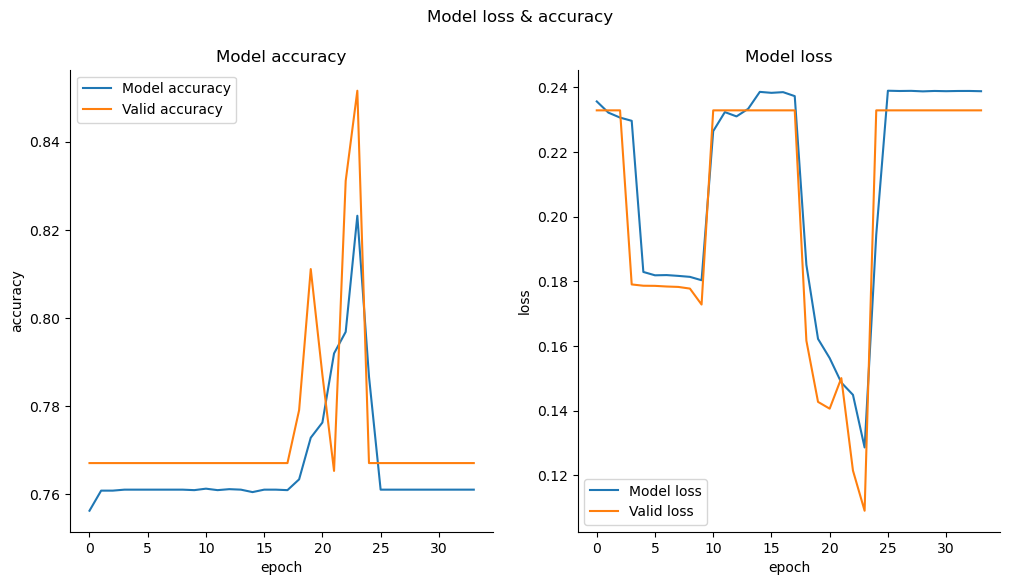

In [43]:
viz_hasil_churn(ann_latih)

In [46]:
print("Hasil Evaluasi Model terhadap Prediksi data test menggunakan NN:")
pred_report_nn(y_test, ann_model.predict(X_test, verbose=0))

Hasil Evaluasi Model terhadap Prediksi data test menggunakan NN:


<IPython.core.display.Javascript object>

Accuracy:  0.760800
Precision:  0.000000
Recall:  0.000000
F1 Score:  0.000000
Loss:  3.813419


### Seems like this model is not good and doesnt fit to use when deploy to an app. so yeah i think Light GBM is still the winner !!